<a href="https://colab.research.google.com/github/aju22/Potrait-Segmentation-BodyPix/blob/main/Background_Subtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and Import Dependencies

In [ ]:
!pip install tf_bodypix
!pip install tfjs_graph_converter

In [149]:
import tensorflow as tf
from tf_bodypix.api import download_model, load_model, BodyPixModelPaths
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL
import cv2

#Load Model

In [150]:
load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))

bodypix_model = load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))

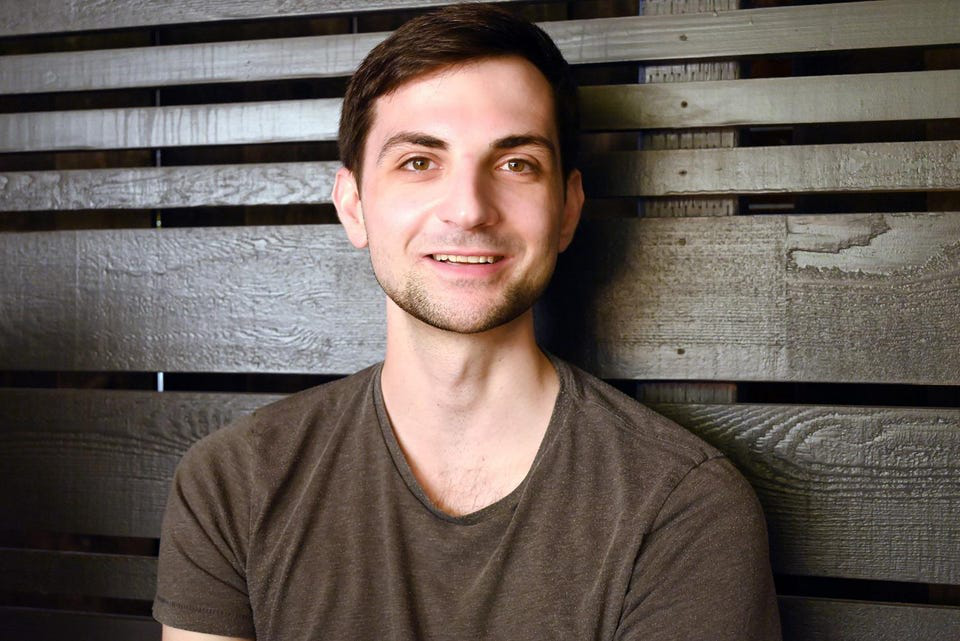

In [258]:
image = PIL.Image.open("0x0.jpg")
image

# Run Model

In [151]:
img = np.array(image)
result = bodypix_model.predict_single(img)
mask = result.get_mask(threshold=0.5).numpy().astype(np.uint8)
masked_image = cv2.bitwise_and(img, img, mask=mask)

# Show Mask

In [226]:
mask_img = np.uint8(mask[:,:,0]*255)

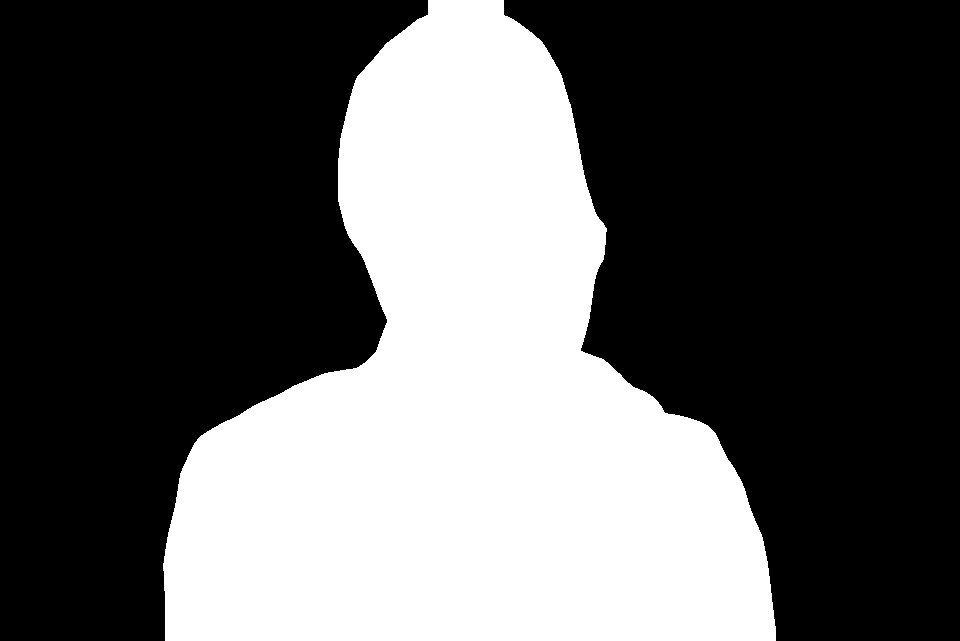

In [227]:
PIL.Image.fromarray(mask_img, 'L')

# Smoothening Mask

In [244]:
smooth_mask_img = cv2.blur(mask_img, (45,45))

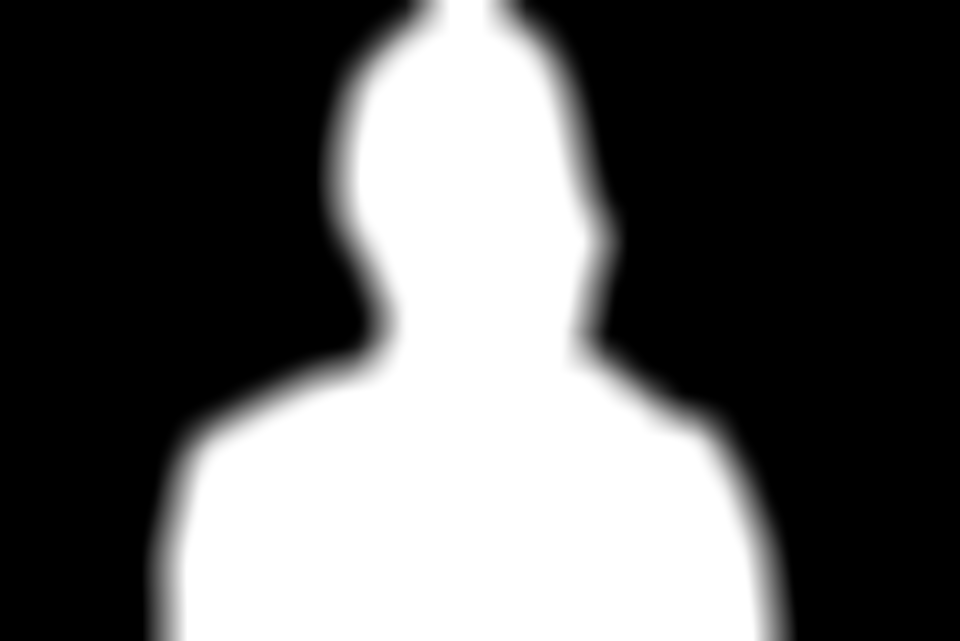

In [245]:
mask_viz = PIL.Image.fromarray(np.uint8(smooth_mask_img), 'L')
mask_viz

# Masked Image

In [247]:
def overlay_image(foreground_image, background_image, foreground_mask):
    background_mask = cv2.cvtColor(255 - cv2.cvtColor(foreground_mask, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    masked_fg = (foreground_image * (1 / 255.0)) * (foreground_mask * (1 / 255.0))
    masked_bg = (background_image * (1 / 255.0)) * (background_mask * (1 / 255.0))
    return np.uint8(cv2.addWeighted(masked_fg, 255.0, masked_bg, 255.0, 0.0))

In [248]:
black_bg = np.zeros_like(img)
smooth_mask = cv2.cvtColor(smooth_mask_img, cv2.COLOR_GRAY2BGR)
smooth_overlay = overlay_image(img, black_bg, smooth_mask)

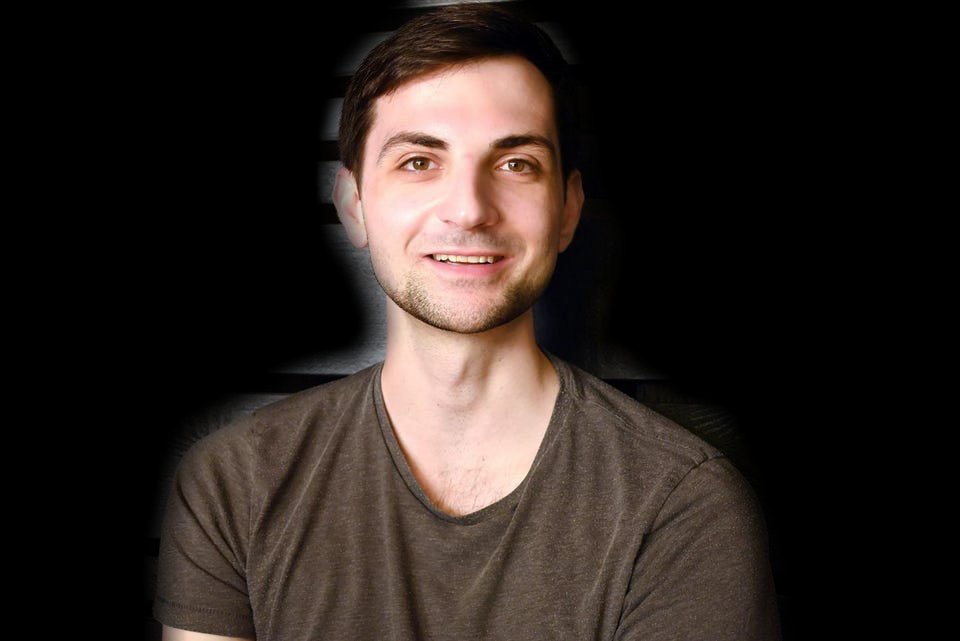

In [249]:
PIL.Image.fromarray(smooth_overlay, 'RGB')

# Bokeh Effect

In [250]:
blur = cv2.GaussianBlur(img, (35, 35), 0)
final = overlay_image(img, blur, smooth_mask)

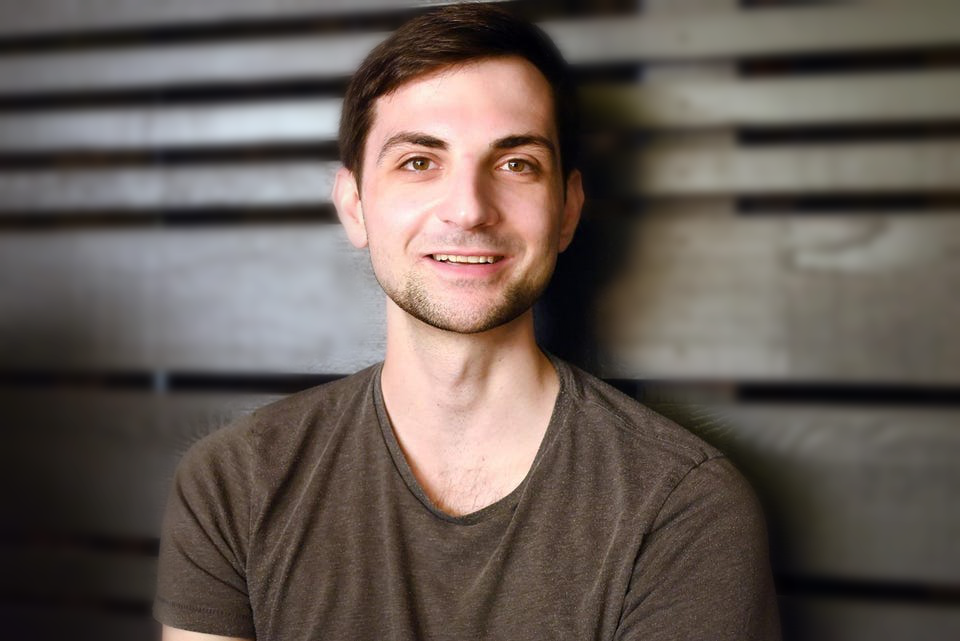

In [251]:
final_image = PIL.Image.fromarray(final, 'RGB')
final_image

# Virtual Background

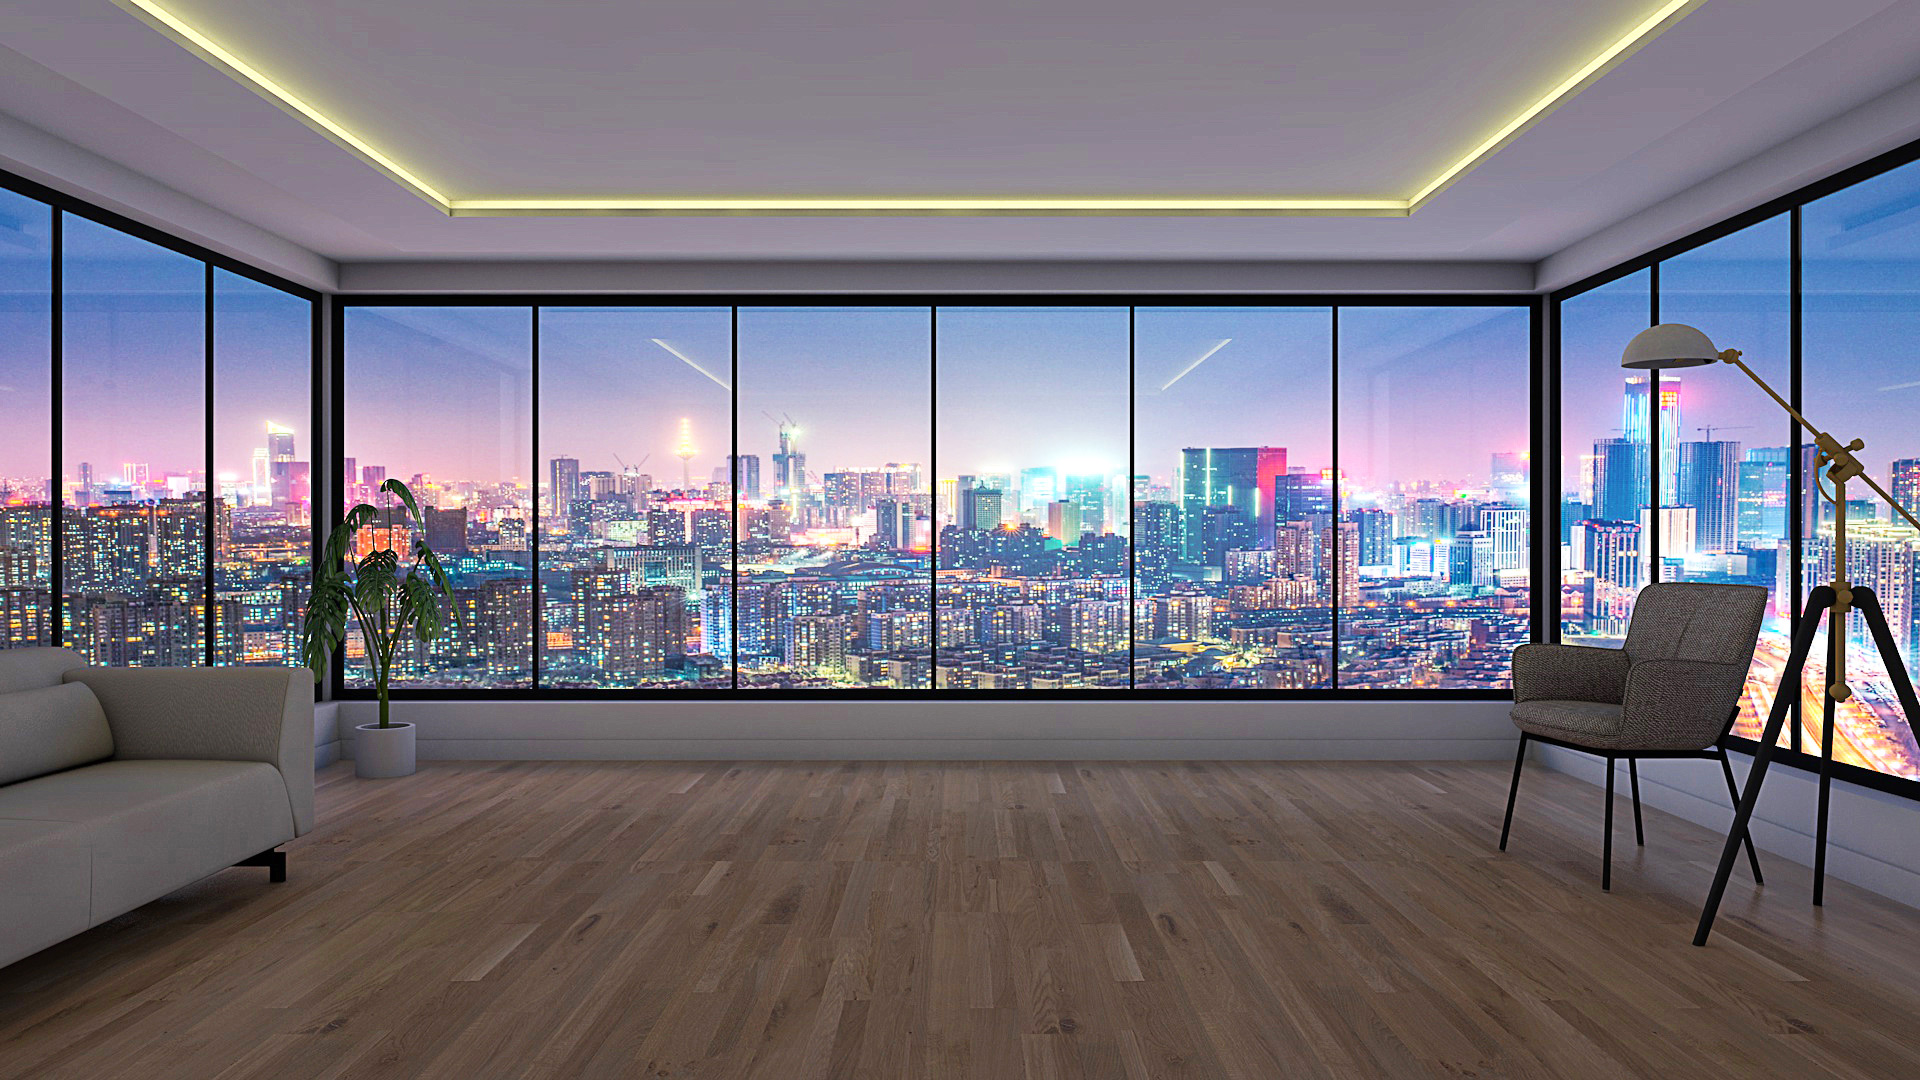

In [254]:
virtual_bg = PIL.Image.open("OfficeZoom_0001.jpg")
bg = np.array(virtual_bg)
virtual_bg

In [255]:
def pad_to_bg(src, bg):
  
  src_w, src_h, ch = src.shape
  width, height, _ = bg.shape
  
  if src_w < width and src_h < height:
    left = (height - src_h)//2
    right = (height - src_h) - left
    top = (width - src_w)
    bottom = 0
    
    new_img = cv2.copyMakeBorder(src, top, bottom, left, right, cv2.BORDER_CONSTANT)
    
    if ch == 1:
      return np.expand_dims(new_img, 2)

    return new_img

  else:
    print("Img file must be smaller than background")  


In [ ]:
new_mask = pad_to_bg(smooth_mask, bg)
new_img = pad_to_bg(img, bg)

In [256]:
out = overlay_image(new_img, bg, new_mask)

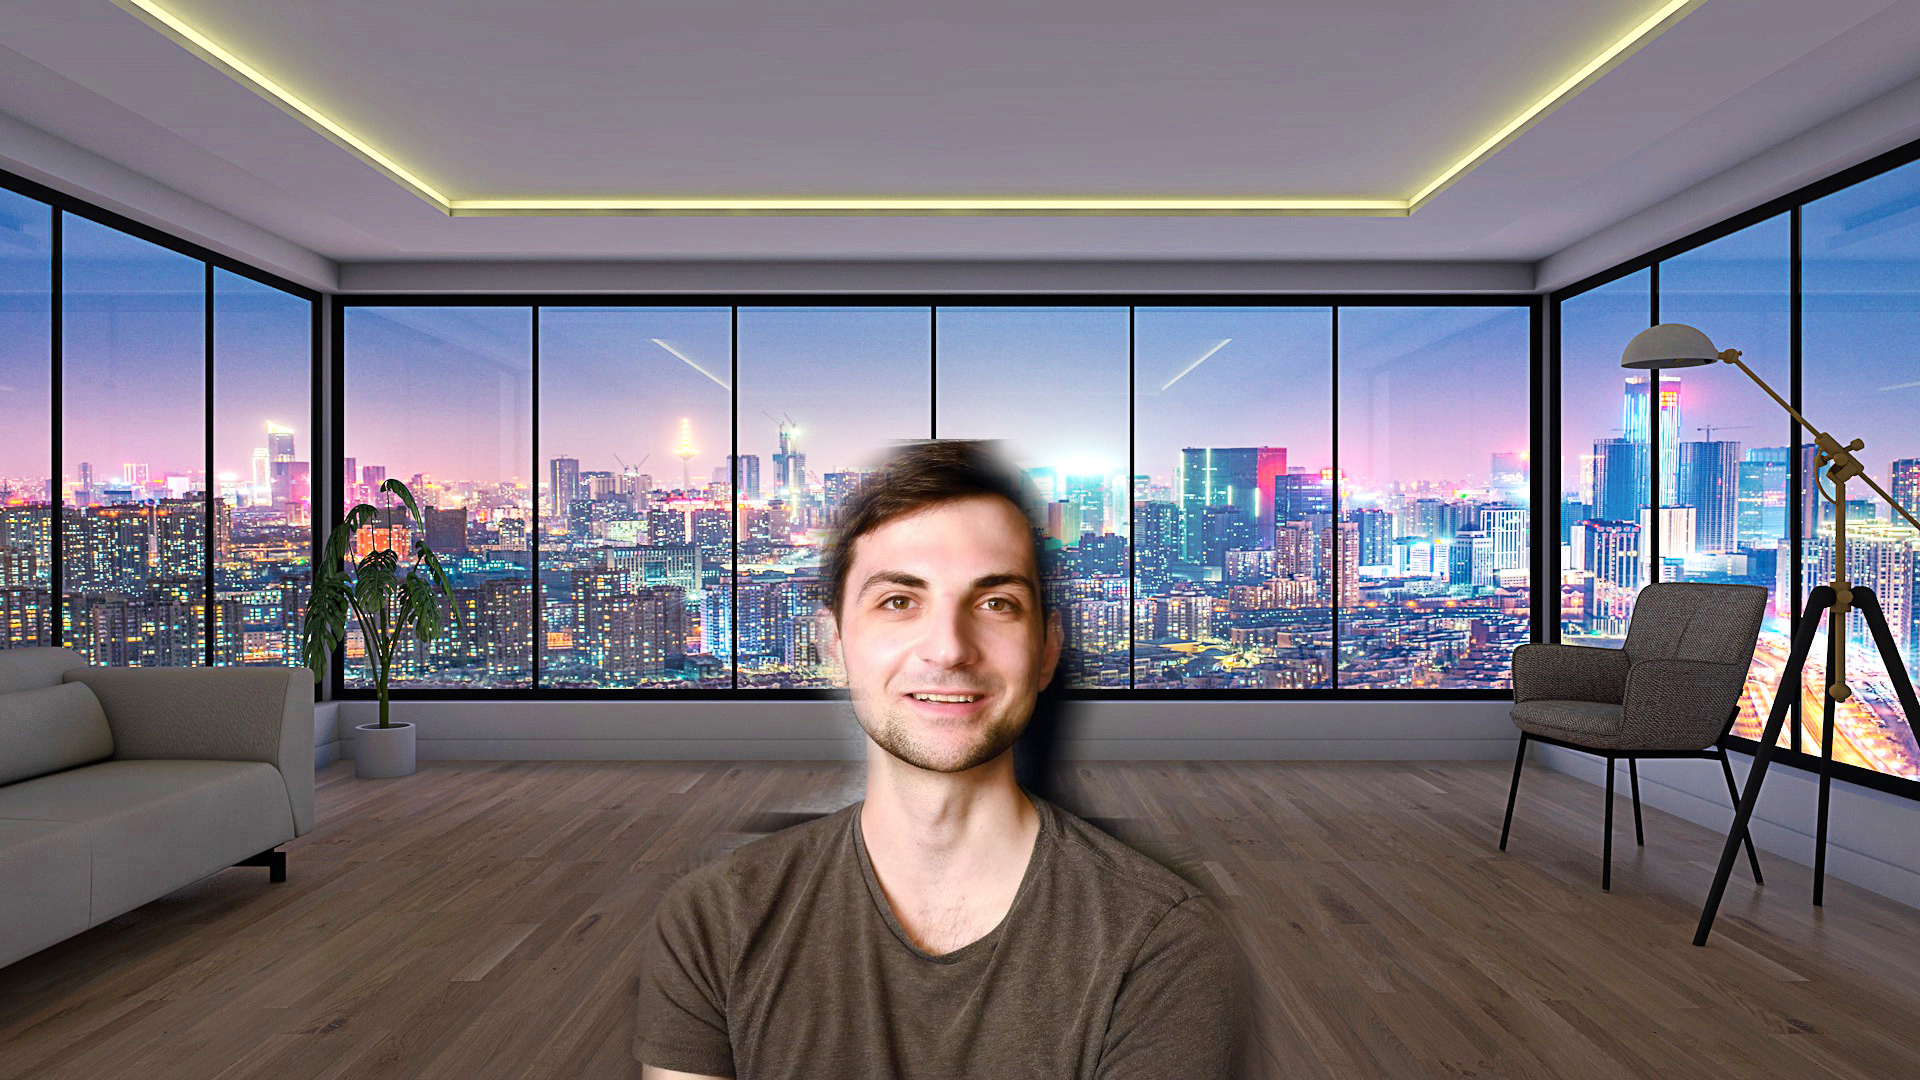

In [257]:
final_image = PIL.Image.fromarray(out, 'RGB')
final_image